In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch 
from tqdm import tqdm

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 18
})

The diffusion equation is expressed as
\begin{equation}
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2},
\end{equation}
where $u(x,t)$ is the solution and D the diffusion coefficient. This equation can be solved using discrete methods (FEM, FVD, FDM) or through other methods like stochastic (random walk)

The solution to the diffusion equation when the initial condition is a delta function is given by
\begin{equation}
u(x,t) = \frac{1}{2\sqrt{Dt}} e^{-\frac{x^2}{4Dt}}
\end{equation}
where the initial condition is
\begin{equation}
u(x=x_0,0) = \delta(x_0)
\end{equation}

Due to the linearlity of the PDE, the diffusion solution can be computed using green's function for any $f(x)$ initial condition. For simplicity, we have taken a gaussian function as initial condition 

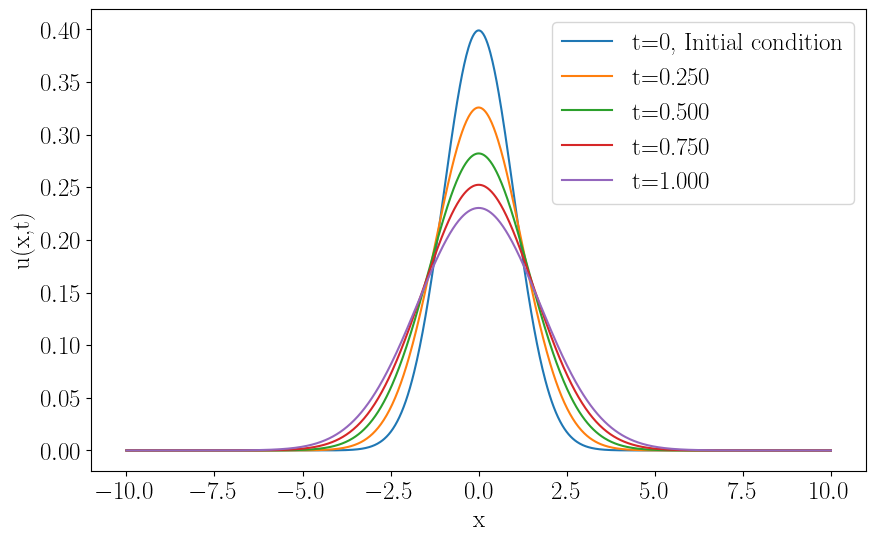

In [2]:
x = np.linspace(-10, 10, 1000)
x_domain = np.linspace(-50,50,5000)
D = 1
t = np.array([0,0.25,0.5,0.75,1])

def G(x, t, D):
    if t <= 0:
        return np.zeros_like(x)  
    return 1 / np.sqrt(4 * np.pi * D * t) * np.exp(-x**2 / (4 * D * t))

def f_0(x):
    sigma = 1
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2))

def solve_diffusion(x, t, D, f_initial, x_domain):
    dx = x_domain[1] - x_domain[0]
    solution = np.zeros_like(x)
    for i, x_i in enumerate(x):
        kernel = G(x_i - x_domain, t, D)
        integrand = kernel * f_initial(x_domain)
        solution[i] = np.trapz(y=integrand, x=x_domain)
    return solution

plt.figure(figsize=(10,6))
plt.plot(x, f_0(x),label=f't=0, Initial condition',alpha=1)
for ti in t[1:]:
    solution = solve_diffusion(x, ti, D, f_0, x_domain)
    plt.plot(x, solution,label=f't={ti:.3f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()


The idea behind PINNs is to define a neural network that in its loss it incorporates the PDE. The loss consists of several parts:

Residual loss - PDE constraint ($\mathcal{L}_{\text{PDE}}$), Boundary conditions ($\mathcal{L}_{\text{BC}}$), Initial conditions ($\mathcal{L}_{\text{IC}}$)

\begin{equation}
 \mathcal{L} = \mathcal{L}_{\text{PDE}} + \lambda_{\text{BC}}\mathcal{L}_{\text{BC}} + \lambda_{\text{IC}}\mathcal{L}_{\text{IC}},
\end{equation}

where $\lambda_{\text{BC}}$ and $\lambda_{\text{IC}}$ are hyperparameters to balance the contributions of the boundary and initial conditions to the total loss.

\begin{equation}
\mathcal{L}_{\text{PDE}} = \frac{1}{N} \sum_{i=1}^{N}{\frac{\partial u_i}{\partial t} - D \frac{\partial^2 u_i}{\partial x^2}}
\end{equation}

\begin{equation}
\mathcal{L}_{\text{BC}} = \frac{1}{N_b} \sum_{i=1}^{N_b}{u(x_b,t_b)-g(x_b,t_b)}
\end{equation}

\begin{equation}
\mathcal{L}_{\text{IC}} = \frac{1}{N} \sum_{i=1}^{N}{u(x_0,0)-h(x_0)}
\end{equation}

The best way I can think of showing how a PINNs network works is by initializing a neural network that learns to converge/optimize towards a simple function. We will then expand this concept to also add the internal condition of the PDE and the boundary conditions needed. As a starting point, let's code a DNN that approximates a gaussian function

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PINN_diffusion(nn.Module):
    def __init__(self, layers):
        super(PINN_diffusion, self).__init__()
        self.layers = nn.ModuleList()
        #can we add batch norm?
        #self.batch_norm = nn.BatchNorm1d(layers[0])
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            nn.init.xavier_normal_(self.layers[-1].weight,gain=2.0)
            nn.init.zeros_(self.layers[-1].bias)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        #add a layer that outputs from 0 to 1
        x = torch.sigmoid(x)
        return x

Now we will define the Initial Condition loss and function. For now, we just impose that at the nodes where $t=0$, $u(x) \to h(x)$

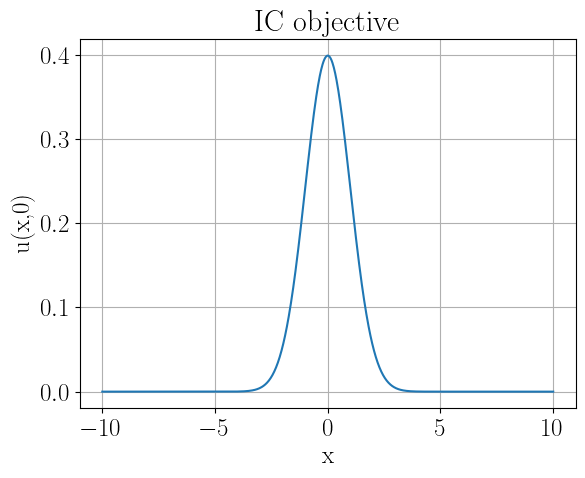

In [71]:
def compute_loss_ic(u, input, h):
    loss_ic = (u-h)**2
    return loss_ic.mean()

def f_0(x, mu=0., sigma=1.0):
    """Gaussian function"""
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu)**2) / (2 * sigma**2))

plt.plot(np.linspace(-10,10,1000),f_0(np.linspace(-10,10,1000)))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.title('IC objective')
plt.grid(True)
plt.show()

Let's define a neural network now that is capable of converging towards this condition, we will see that some difficulties start appearing. Before that, let's first code a function that is capable to return points within the interested domain

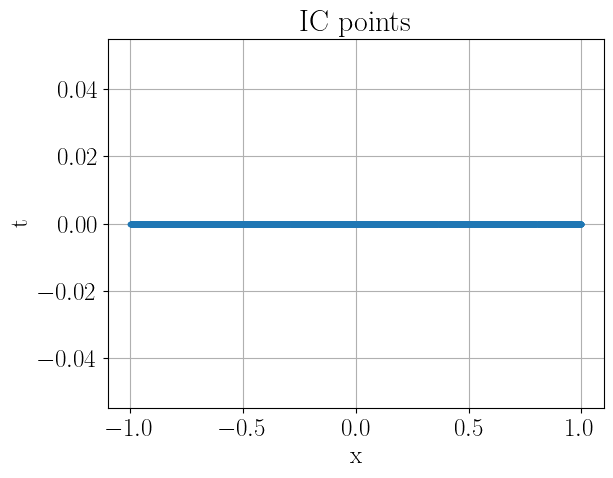

In [169]:
def obtain_points(N, range_x, range_t):
    if type(range_x) == tuple:        
        x = np.random.uniform(range_x[0],range_x[1],N)
    else:
        x = np.ones_like(x)*range_x
    if type(range_t) == tuple:
        t = np.random.uniform(range_t[0],range_t[1],N)
    else:
        t = np.ones_like(x)*range_t
    points = np.stack((x,t),axis=1)
    return points

points_ic = obtain_points(N=5000,range_x=(-1,1),range_t=0)
plt.plot(points_ic[:,0],points_ic[:,1],'.')
plt.xlabel('x')
plt.ylabel('t')
plt.title('IC points')
plt.grid(True)
plt.show()

Let's now define a network and train it to match IC points using the previous defined loss

In [93]:
def train_network(nn, points, epochs, optimizer, f_loss, loss_args={}, device="mps" if torch.mps.is_available() else "cpu"):
    nn.train()
    nn.to(device)
    points = torch.tensor(points, dtype=torch.float32,requires_grad=True)
    points = points.to(device)
    pbar = tqdm(range(epochs),desc="Training")
    
    plt.figure(figsize=(8,6))
    colors = plt.cm.viridis(np.linspace(0, 1, epochs//250 + 1))  # Color gradient
    color_idx = 0
    
    for epoch in pbar:
        def closure():
            optimizer.zero_grad()   
            u = nn(points)
            loss = f_loss(u, points, **loss_args)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        pbar.set_description(f"Epoch {epoch}, Loss: {loss.item()}")
        
        def validate(t=0.):
            x_val = torch.linspace(-10, 10, 100, device=device)
            x_val /= 10
            t_val = torch.full_like(x_val, t)
            val_points = torch.stack((x_val, t_val), dim=1)
            with torch.no_grad():
                return nn(val_points).cpu().numpy(), x_val.cpu().numpy()
        
        if epoch % 250 == 0:
            t_val = 0.
            u_pred, x_val = validate(t=t_val)
            x_val*=10
            
            # Plot with increasing opacity and different colors
            alpha = (epoch/epochs + 0.3)  # Opacity increases with epochs
            alpha = min(alpha, 1.0)  # Cap opacity at 1.0
            
            plt.plot(x_val, u_pred, color=colors[color_idx], 
                    alpha=alpha, label=f'Epoch {epoch}')
            if epoch == 0:  # Plot target only once
                plt.plot(x_val, f_0(x_val), '--k', label='Target', alpha=0.8)
            
            plt.xlabel('x')
            plt.ylabel('u(x,t)')
            color_idx += 1
    
    return nn

nn = PINN_diffusion([2,32,64,128,128,64,32,1])
lr = 0.001
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
h = torch.tensor(f_0(points_ic[:,0]), dtype=torch.float32,requires_grad=True)
device = "mps" if torch.mps.is_available() else "cpu"
h = h.to(device)
loss_args = {"h":h}
points_ic[:,0] /= 10
trained_nn = train_network(nn, points_ic, epochs=1000, optimizer=optimizer, f_loss=compute_loss_ic, loss_args=loss_args)
plt.legend()
plt.show()


AttributeError: 'PINN_diffusion' object has no attribute 'ModuleList'

Changing the optimizer does not help converging to the IC, neither does adding more variance to the initialisation of the weights. We need to enforce more spatial conditions for the neural network to learn like information on the derivatives. 

In [135]:
def f_0(x, mu=0., sigma=1.0, scale=1.0):
    x = x*scale
    """Gaussian function"""
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu)**2) / (2 * sigma**2))

def f_0_prime(x, mu=0., sigma=1.0, scale=1.0):
    """First derivative of the Gaussian function."""
    return scale * (-((x*scale - mu) / sigma**2) * f_0(x, mu, sigma, scale))

def f_0_double_prime(x, mu=0., sigma=1.0, scale=1.0):
    """Second derivative of the Gaussian function."""
    return scale * (-scale * f_0(x, mu, sigma, scale) + f_0(x, mu, sigma, scale) * -(x*scale-mu)**2/sigma**4 * -scale)

def compute_loss_ic_derivatives(u, input, h, h_prime, h_double_prime):
    loss_ic = (u-h)**2
    ux = torch.autograd.grad(u, input, grad_outputs=torch.ones_like(u), create_graph=True)[0][:,0]
    uxx = torch.autograd.grad(ux, input, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,0]
    loss_ic_prime = 0.1*(ux-h_prime)**2
    loss_ic_double_prime = 0.01*(uxx-h_double_prime)**2
    total_loss = loss_ic.mean() + loss_ic_prime.mean() + loss_ic_double_prime.mean()
    return total_loss.mean()

Epoch 4999, Loss: 0.022251524031162262: 100%|██████████| 5000/5000 [04:22<00:00, 19.04it/s]


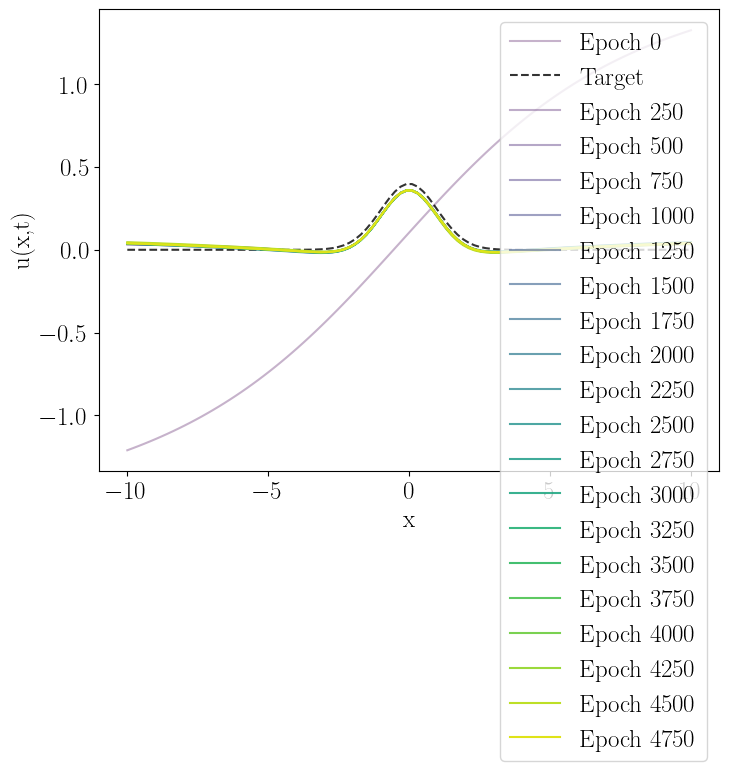

In [172]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PINN_diffusion(nn.Module):
    def __init__(self, layers):
        super(PINN_diffusion, self).__init__()
        self.layers = nn.ModuleList()
        #can we add batch norm?
        #self.batch_norm = nn.BatchNorm1d(layers[0])
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            nn.init.xavier_normal_(self.layers[-1].weight,gain=1.0)
            nn.init.zeros_(self.layers[-1].bias)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        #add a layer that outputs from 0 to 1
        return x
    

def train_network(nn, points, epochs, optimizer, f_loss, loss_args={}, device="mps" if torch.mps.is_available() else "cpu"):
    nn.train()
    nn.to(device)
    points = torch.tensor(points, dtype=torch.float32,requires_grad=True)
    points = points.to(device)
    pbar = tqdm(range(epochs),desc="Training")
    
    plt.figure(figsize=(8,6))
    colors = plt.cm.viridis(np.linspace(0, 1, epochs//250 + 1))  # Color gradient
    color_idx = 0
    
    for epoch in pbar:
        def closure():
            optimizer.zero_grad()   
            u = nn(points)
            loss = f_loss(u, points, **loss_args)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        pbar.set_description(f"Epoch {epoch}, Loss: {loss.item()}")
        
        def validate(t=0.):
            x_val = torch.linspace(-10, 10, 100, device=device)
            x_val /= 10
            t_val = torch.full_like(x_val, t)
            val_points = torch.stack((x_val, t_val), dim=1)
            with torch.no_grad():
                return nn(val_points).cpu().numpy(), x_val.cpu().numpy()
        
        if epoch % 250 == 0:
            t_val = 0.
            u_pred, x_val = validate(t=t_val)
            x_val*=10
            
            # Plot with increasing opacity and different colors
            alpha = (epoch/epochs + 0.3)  # Opacity increases with epochs
            alpha = min(alpha, 1.0)  # Cap opacity at 1.0
            
            plt.plot(x_val, u_pred, color=colors[color_idx], 
                    alpha=alpha, label=f'Epoch {epoch}')
            if epoch == 0:  # Plot target only once
                plt.plot(x_val, f_0(x_val), '--k', label='Target', alpha=0.8)
            
            plt.xlabel('x')
            plt.ylabel('u(x,t)')
            color_idx += 1
    
    return nn


nn = PINN_diffusion([2,32,64,128,256,320,256,128,64,32,1])
lr = 0.001
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
#optimizer = torch.optim.LBFGS(nn.parameters(), lr=lr, max_iter=20)
h = torch.tensor(f_0(points_ic[:,0],scale=10), dtype=torch.float32,requires_grad=True)
h_prime = torch.tensor(f_0_prime(points_ic[:,0],scale=10), dtype=torch.float32,requires_grad=True)
h_double_prime = torch.tensor(f_0_double_prime(points_ic[:,0],scale=10), dtype=torch.float32,requires_grad=True) 
device = "mps" if torch.mps.is_available() else "cpu"
h = h.to(device)

h_prime = h_prime.to(device)
h_double_prime = h_double_prime.to(device)
loss_args = {"h":h, "h_prime":h_prime, "h_double_prime":h_double_prime}

trained_nn = train_network(nn, points_ic, epochs=5000, optimizer=optimizer, f_loss=compute_loss_ic_derivatives, loss_args=loss_args)

plt.legend()
plt.show()